In [1]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time

from torch.nn import LSTM


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
def visualize_graph(G, window_index,visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()

def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()

def train_model(model, train_loader, optimizer, criterion,title,result_dir, epochs=100):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/traing_loss_over_epochs_{title}.png')
    plt.show()

def evaluate_model(model, test_loader, title,result_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred,output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title,result_dir)
    
    return cm, report

# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)



In [3]:
def load_saved_graphs(graph_dir):
    pyg_data_list = []
    for graph_file in sorted(os.listdir(graph_dir)):
        if graph_file.endswith('.graphml'):
            graph_path = os.path.join(graph_dir, graph_file)
            G = nx.read_graphml(graph_path)
            
            # Convert networkx graph to PyG data object
            pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
            pyg_data.x = pyg_data.x.float()  # Ensure x is Float
            
            # Assuming labels are stored in the graph attributes
            labels = [G.nodes[node]['label'] for node in G.nodes]
            pyg_data.y = torch.tensor(labels, dtype=torch.long)
            
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [4]:

class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    

def run_GCnn(train_loader,test_loader,title,result_dir):

    model = GCNN(in_channels=1, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    train_model(model, train_loader, optimizer, criterion,title,title_dir)
    cm, report = evaluate_model(model, test_loader,title,title_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

In [5]:
# new_execution_flag = input("Do u want new execution")
# new_execution_flag
def assign_value():
    user_input = input("Please enter 'yes' or 'no': ").strip().lower()
    
    if user_input == '1':
        return 1
    elif user_input == '0':
        return 0
    else:
        print("Invalid input. Please enter '1' or '0'.")
        return assign_value()
    
# assigned_value = assign_value()

In [6]:
new_execution_flag = assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)
else:
    # folder_name = input("Input folder name from all_execution_data")
    folder_name = '2024-07-10_15-26-40'
    

In [7]:
folder_name


'2024-07-10_15-26-40'

In [8]:
def preprocess_data(data,output_dir,visualization_dir):
    print("inside preprocess")

data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx']

type10_label
2074
Epoch 1, Loss: 0.46755667160386627


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2, Loss: 0.5703535280797792
Epoch 3, Loss: 0.4332156949069189
Epoch 4, Loss: 0.39739822207585623
Epoch 5, Loss: 0.34992205513560254
Epoch 6, Loss: 0.32012676771568216
Epoch 7, Loss: 0.3066017883627311
Epoch 8, Loss: 0.29897153523305187
Epoch 9, Loss: 0.2927850706745749
Epoch 10, Loss: 0.28566616093334946
Epoch 11, Loss: 0.2788201381816812
Epoch 12, Loss: 0.2770339457885079
Epoch 13, Loss: 0.26673439801063226
Epoch 14, Loss: 0.26226867168493895
Epoch 15, Loss: 0.2606198773921832
Epoch 16, Loss: 0.25618597492575645
Epoch 17, Loss: 0.2547962700381227
Epoch 18, Loss: 0.2484476550117783
Epoch 19, Loss: 0.2520117971074322
Epoch 20, Loss: 0.251855891926781
Epoch 21, Loss: 0.2518529804504436
Epoch 22, Loss: 0.2500880631091802
Epoch 23, Loss: 0.24702562731893166
Epoch 24, Loss: 0.2490389585171057
Epoch 25, Loss: 0.24728883276491062
Epoch 26, Loss: 0.24346308474955353
Epoch 27, Loss: 0.24565767302461292
Epoch 28, Loss: 0.24703904427587986
Epoch 29, Loss: 0.2414762015737917
Epoch 30, Loss: 

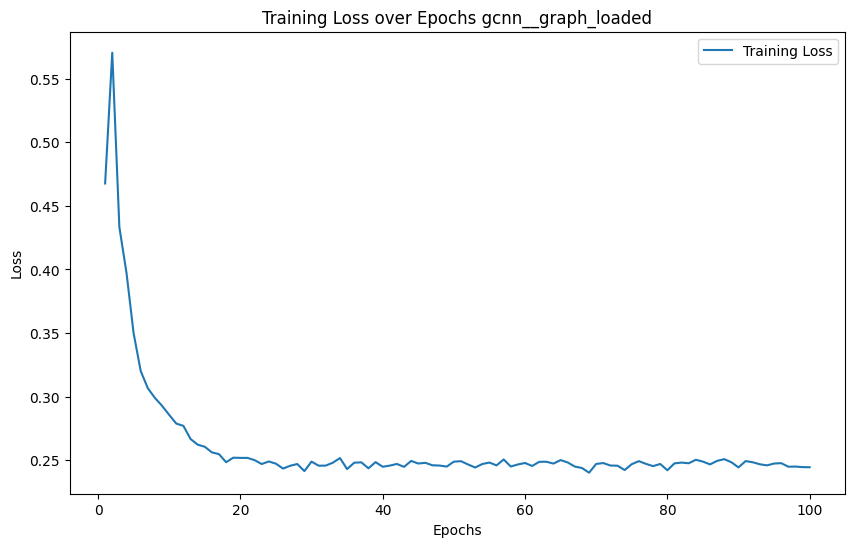

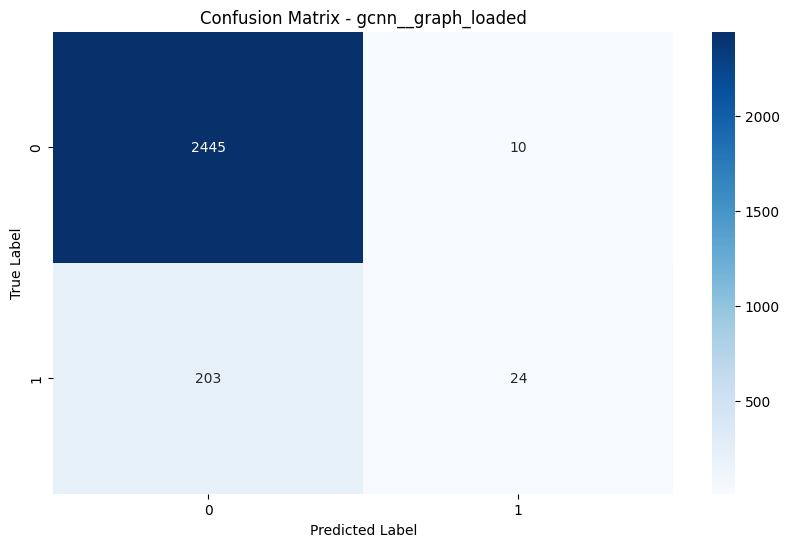

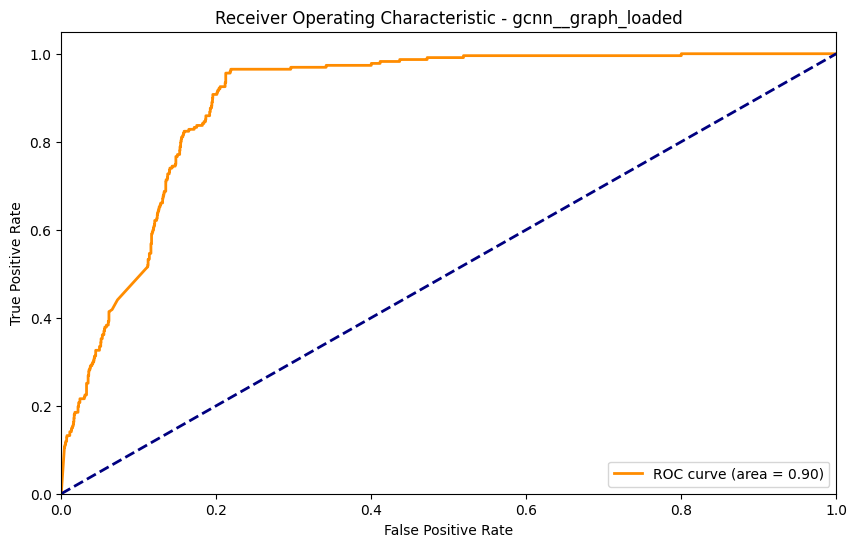

type1_label_
2079
Epoch 1, Loss: 0.6077712709489076


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2, Loss: 0.4154830325556838
Epoch 3, Loss: 0.3988067622741927
Epoch 4, Loss: 0.3983985277945581
Epoch 5, Loss: 0.3895005345668482
Epoch 6, Loss: 0.3878696947965933
Epoch 7, Loss: 0.38963893039718916
Epoch 8, Loss: 0.38632961864704674
Epoch 9, Loss: 0.3822709304159102
Epoch 10, Loss: 0.3834734640043715
Epoch 11, Loss: 0.378482605614092
Epoch 12, Loss: 0.3797088707594768
Epoch 13, Loss: 0.3826003029294636
Epoch 14, Loss: 0.37990568724015483
Epoch 15, Loss: 0.37864315428811574
Epoch 16, Loss: 0.3812295643855696
Epoch 17, Loss: 0.3803838834814403
Epoch 18, Loss: 0.37556931862364645
Epoch 19, Loss: 0.3749717535532039
Epoch 20, Loss: 0.3752825172699016
Epoch 21, Loss: 0.373460176360348
Epoch 22, Loss: 0.37542696831666905
Epoch 23, Loss: 0.3758264020409273
Epoch 24, Loss: 0.37022440475614177
Epoch 25, Loss: 0.3743518777191639
Epoch 26, Loss: 0.3741957569575828
Epoch 27, Loss: 0.37774593755602837
Epoch 28, Loss: 0.3746772734043391
Epoch 29, Loss: 0.37283786046116246
Epoch 30, Loss: 0.373

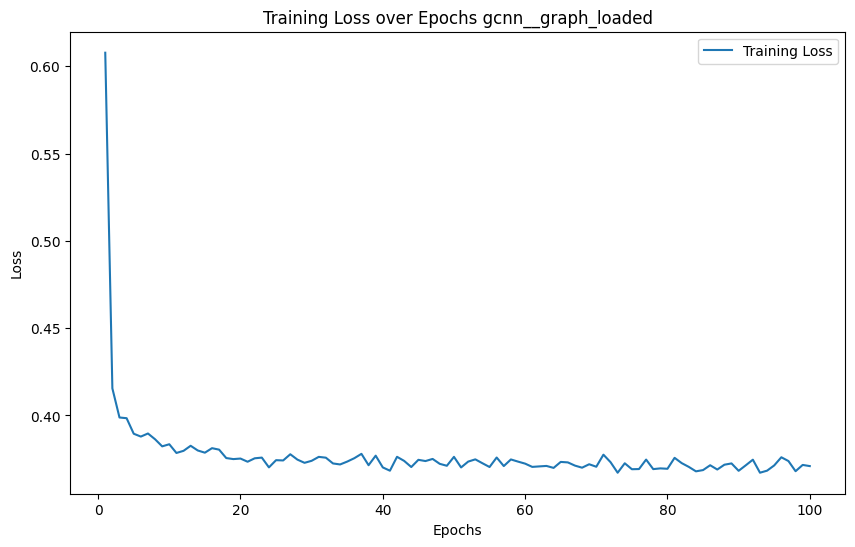

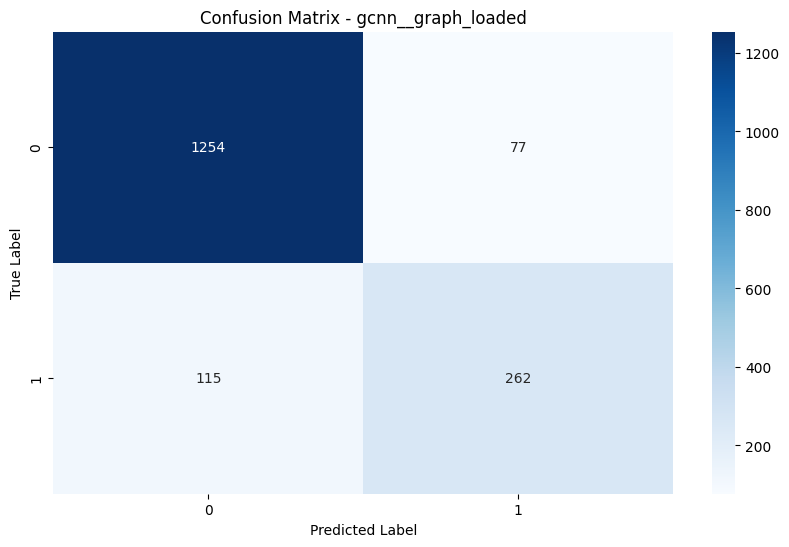

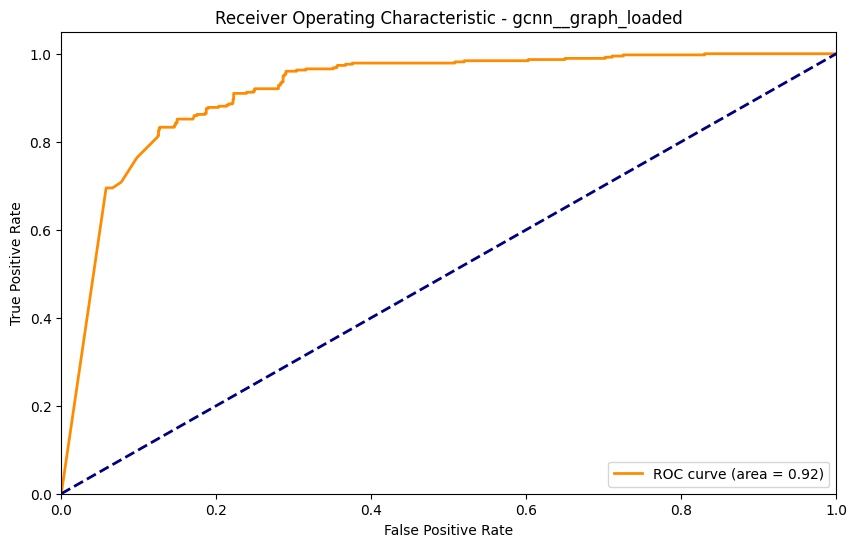

type2_label_
1342
Epoch 1, Loss: 0.5596819480260213


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2, Loss: 0.283587629472216
Epoch 3, Loss: 0.2737911095221837
Epoch 4, Loss: 0.2626267299056053
Epoch 5, Loss: 0.25907131483157475
Epoch 6, Loss: 0.2518000262478987
Epoch 7, Loss: 0.24694554060697554
Epoch 8, Loss: 0.24089835608998936
Epoch 9, Loss: 0.2338828757405281
Epoch 10, Loss: 0.22738726461927097
Epoch 11, Loss: 0.22288526482880117
Epoch 12, Loss: 0.21812944238384566
Epoch 13, Loss: 0.21652962043881416
Epoch 14, Loss: 0.2146304991096258
Epoch 15, Loss: 0.21484485877056916
Epoch 16, Loss: 0.21412094111243885
Epoch 17, Loss: 0.21038382115463417
Epoch 18, Loss: 0.20992646763722103
Epoch 19, Loss: 0.2068414531648159
Epoch 20, Loss: 0.20731148757040502
Epoch 21, Loss: 0.20492639901737372
Epoch 22, Loss: 0.20494465020795663
Epoch 23, Loss: 0.20574733813603718
Epoch 24, Loss: 0.20431367220977942
Epoch 25, Loss: 0.2017066992819309
Epoch 26, Loss: 0.20270485704143842
Epoch 27, Loss: 0.2018188189715147
Epoch 28, Loss: 0.20391941852867604
Epoch 29, Loss: 0.20057291649281977
Epoch 30, 

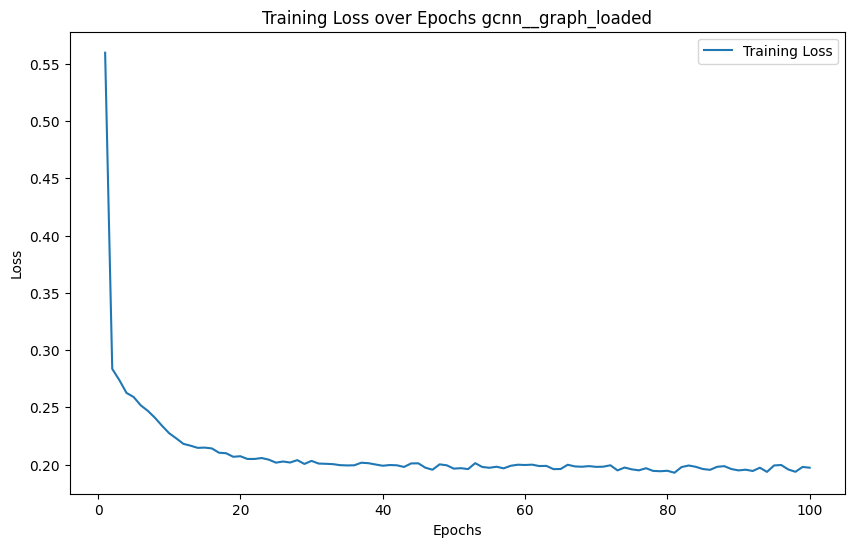

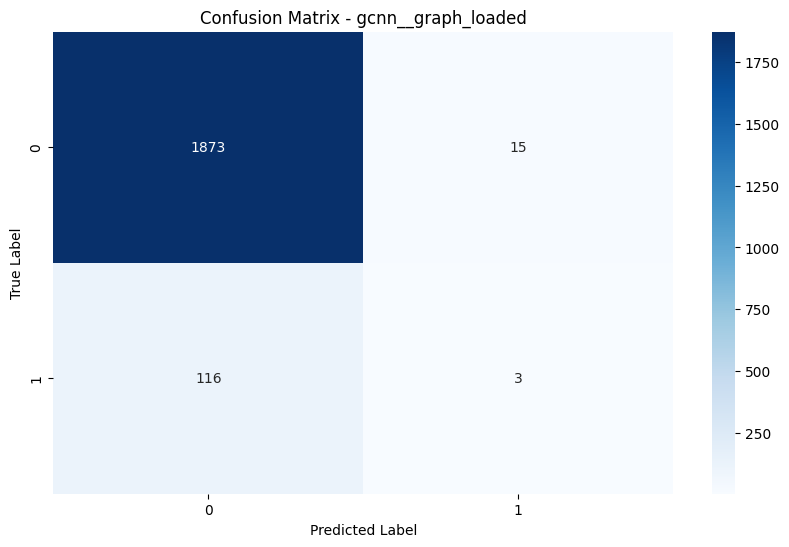

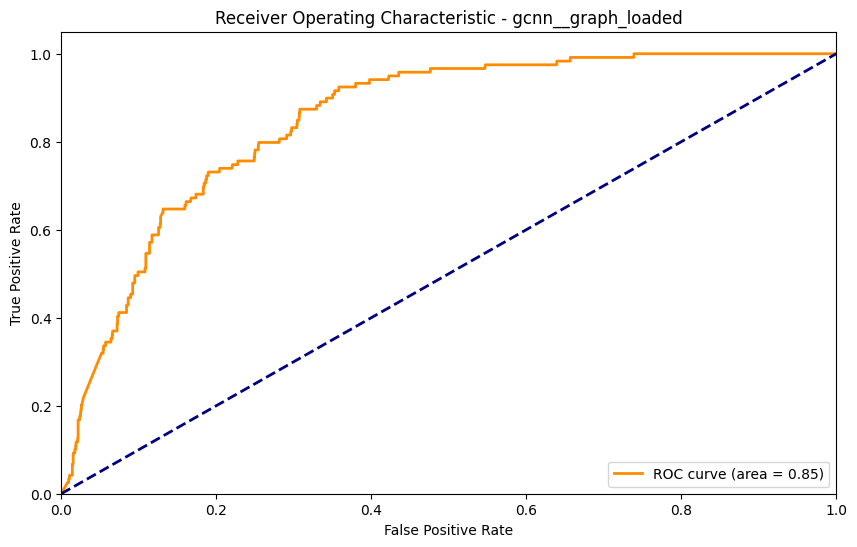

type3_label_
1975
Epoch 1, Loss: 0.5355562405152754


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2, Loss: 0.45877516574480315
Epoch 3, Loss: 0.39907449382272636
Epoch 4, Loss: 0.3811863340776075
Epoch 5, Loss: 0.3755707325921817
Epoch 6, Loss: 0.3734045885503292
Epoch 7, Loss: 0.37297562696039677
Epoch 8, Loss: 0.37019487538120965
Epoch 9, Loss: 0.3671042788773775
Epoch 10, Loss: 0.36335004815323785
Epoch 11, Loss: 0.3622634886679324
Epoch 12, Loss: 0.36483528244901786
Epoch 13, Loss: 0.3625108433718031
Epoch 14, Loss: 0.35623914951627905
Epoch 15, Loss: 0.36038285747847776
Epoch 16, Loss: 0.35792781751264224
Epoch 17, Loss: 0.358869046819481
Epoch 18, Loss: 0.354105885902589
Epoch 19, Loss: 0.360677858306603
Epoch 20, Loss: 0.3583407009189779
Epoch 21, Loss: 0.3586183203892274
Epoch 22, Loss: 0.35119691728190944
Epoch 23, Loss: 0.35344854318960145
Epoch 24, Loss: 0.3532672815702178
Epoch 25, Loss: 0.35712463493374264
Epoch 26, Loss: 0.3523878893730315
Epoch 27, Loss: 0.35462239892645314
Epoch 28, Loss: 0.3536212532357736
Epoch 29, Loss: 0.35002570565451274
Epoch 30, Loss: 0

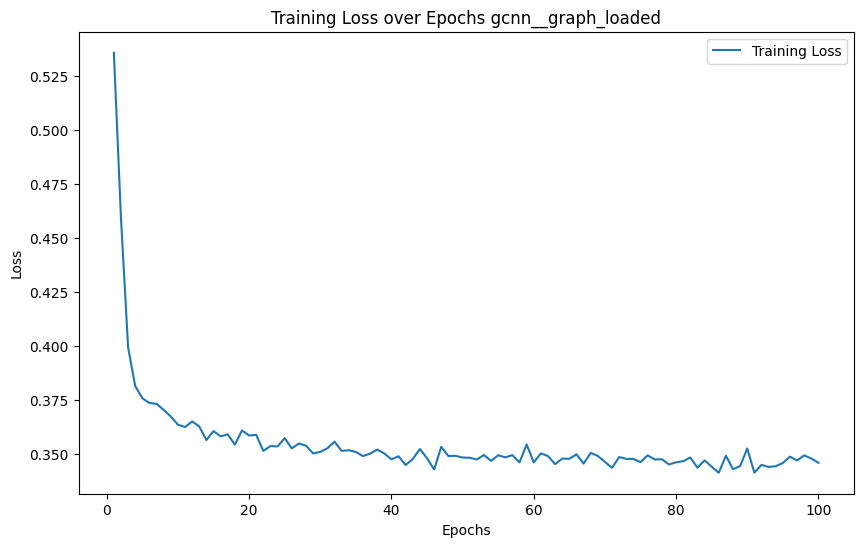

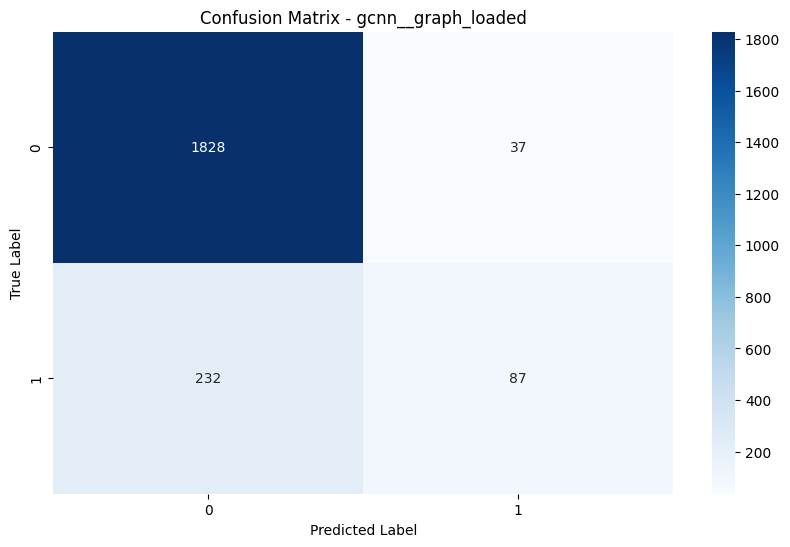

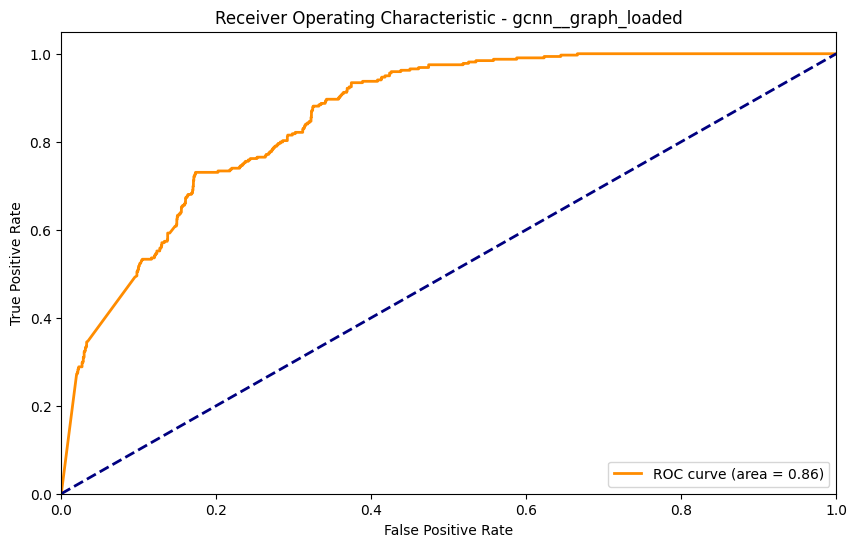

type4_label_
1334
Epoch 1, Loss: 0.4668810690442721


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2, Loss: 0.22670535147190093
Epoch 3, Loss: 0.2214504155019919
Epoch 4, Loss: 0.21923250245551268
Epoch 5, Loss: 0.2162305511534214
Epoch 6, Loss: 0.21440098273257416
Epoch 7, Loss: 0.21295501738786698
Epoch 8, Loss: 0.21055396348237992
Epoch 9, Loss: 0.20928234606981277
Epoch 10, Loss: 0.20687558551629384
Epoch 11, Loss: 0.2043741160382827
Epoch 12, Loss: 0.20160520561039447
Epoch 13, Loss: 0.19950866997241973
Epoch 14, Loss: 0.1958138346672058
Epoch 15, Loss: 0.1942096620798111
Epoch 16, Loss: 0.1913551344225804
Epoch 17, Loss: 0.1889496810734272
Epoch 18, Loss: 0.18625246398150921
Epoch 19, Loss: 0.18429664559662343
Epoch 20, Loss: 0.18273514745136102
Epoch 21, Loss: 0.18005300536751748
Epoch 22, Loss: 0.17986673712730408
Epoch 23, Loss: 0.17826332934200764
Epoch 24, Loss: 0.17543950093289215
Epoch 25, Loss: 0.1756771335999171
Epoch 26, Loss: 0.17428362282613913
Epoch 27, Loss: 0.1766449110582471
Epoch 28, Loss: 0.1749037398646275
Epoch 29, Loss: 0.17498404110471408
Epoch 30, 

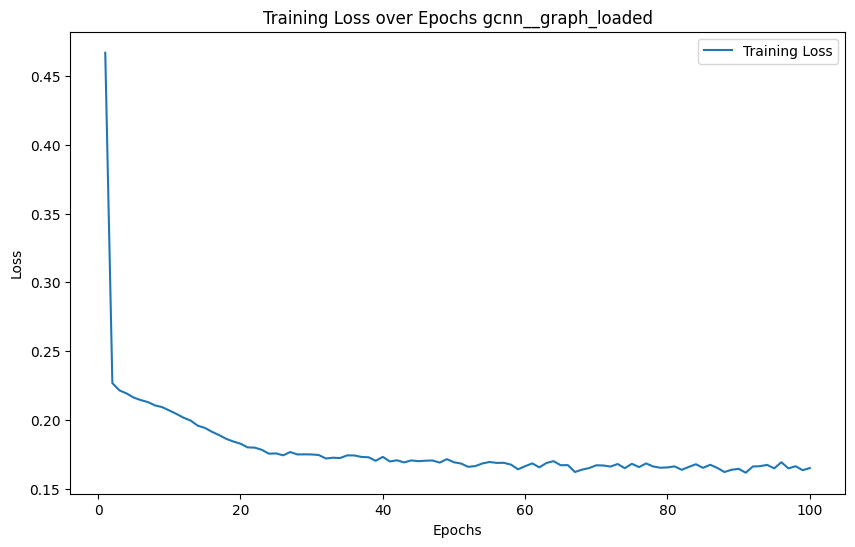

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

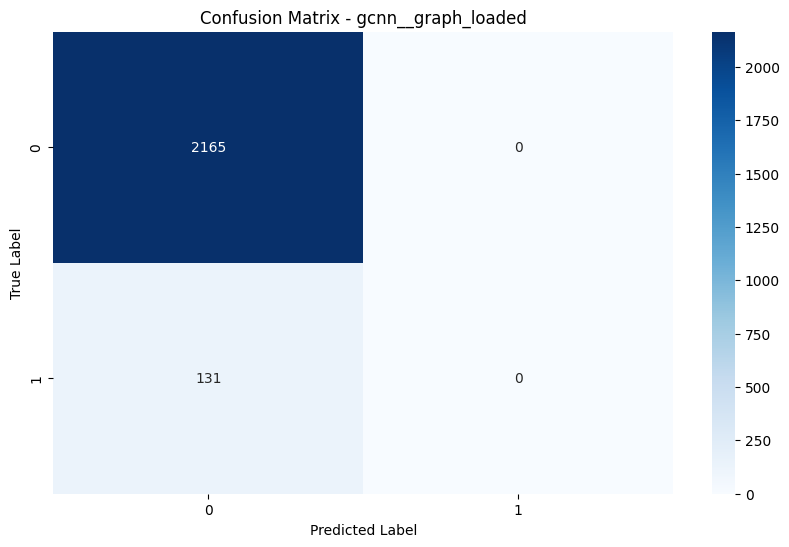

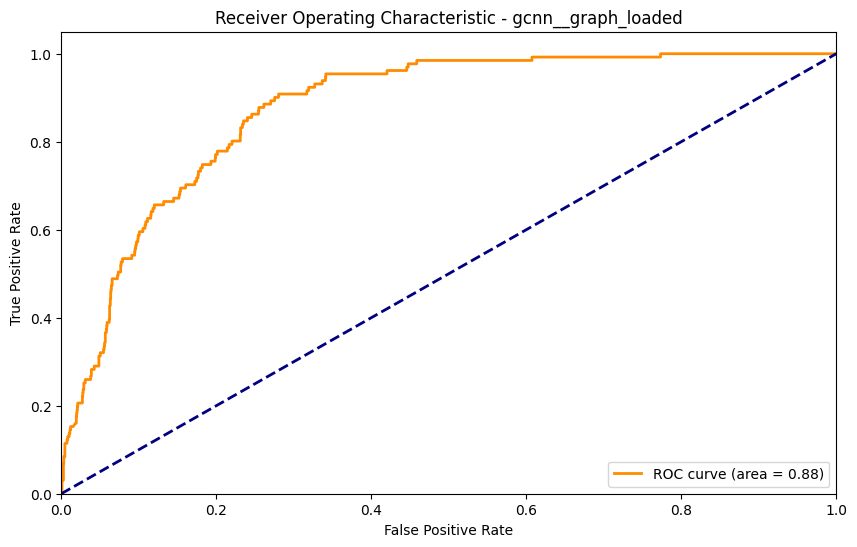

type5_label_
1807
Epoch 1, Loss: 0.4442606452852488


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2, Loss: 0.29082347061485053
Epoch 3, Loss: 0.27962697893381117
Epoch 4, Loss: 0.27250358182936907
Epoch 5, Loss: 0.2628716705366969
Epoch 6, Loss: 0.2520687649026513
Epoch 7, Loss: 0.24005350340157747
Epoch 8, Loss: 0.2283768193796277
Epoch 9, Loss: 0.2182593544945121
Epoch 10, Loss: 0.20956403044983746
Epoch 11, Loss: 0.20365908769890667
Epoch 12, Loss: 0.19982776045799255
Epoch 13, Loss: 0.19501915299333633
Epoch 14, Loss: 0.19268180709332228
Epoch 15, Loss: 0.1907775710336864
Epoch 16, Loss: 0.18680619127117098
Epoch 17, Loss: 0.1855448057409376
Epoch 18, Loss: 0.1805917276069522
Epoch 19, Loss: 0.18023079917766155
Epoch 20, Loss: 0.17861348185688258
Epoch 21, Loss: 0.17666012314148247
Epoch 22, Loss: 0.17718352954834699
Epoch 23, Loss: 0.1740205688867718
Epoch 24, Loss: 0.1732914386782795
Epoch 25, Loss: 0.17471893676556646
Epoch 26, Loss: 0.17040270739234983
Epoch 27, Loss: 0.1730454125441611
Epoch 28, Loss: 0.1715033098589629
Epoch 29, Loss: 0.17233347203582525
Epoch 30, L

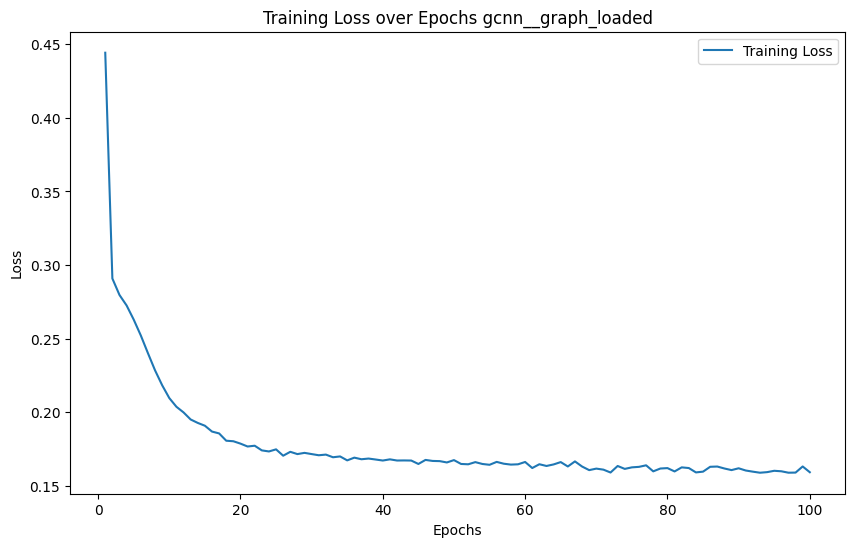

c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

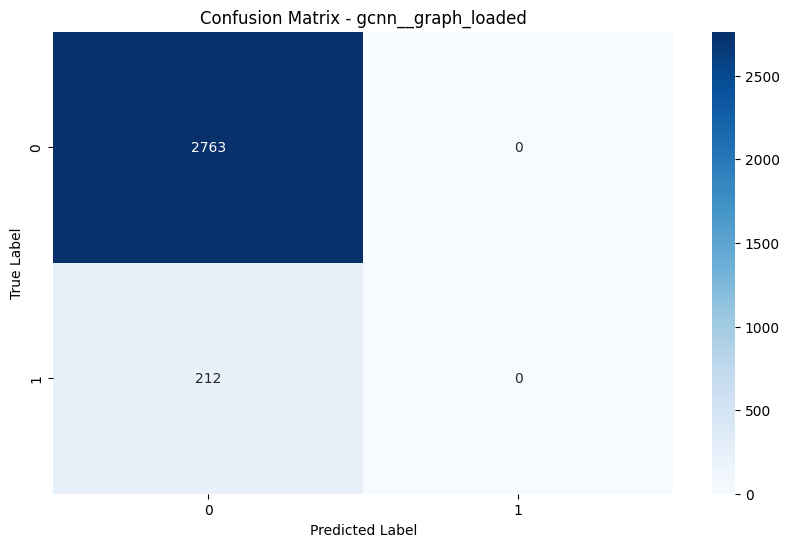

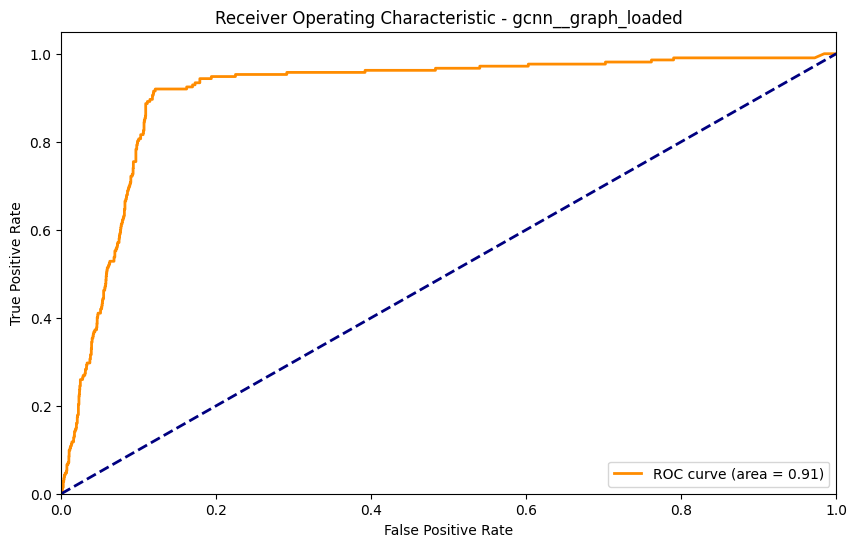

type6_label_
2414


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.4027982490523806
Epoch 2, Loss: 0.29460921630544484
Epoch 3, Loss: 0.2872592013961864
Epoch 4, Loss: 0.27859994066211413
Epoch 5, Loss: 0.26763352372173993
Epoch 6, Loss: 0.2562235752647778
Epoch 7, Loss: 0.2435325062218702
Epoch 8, Loss: 0.23138490248963517
Epoch 9, Loss: 0.22167949926740718
Epoch 10, Loss: 0.21435293976990683
Epoch 11, Loss: 0.2082329921705543
Epoch 12, Loss: 0.20672142301809113
Epoch 13, Loss: 0.20091027309590914
Epoch 14, Loss: 0.1985871433368269
Epoch 15, Loss: 0.19729917637019787
Epoch 16, Loss: 0.19637670367956161
Epoch 17, Loss: 0.1944509322210303
Epoch 18, Loss: 0.19455204988425634
Epoch 19, Loss: 0.19091333216934833
Epoch 20, Loss: 0.19270110010819616
Epoch 21, Loss: 0.1912807973347745
Epoch 22, Loss: 0.188575545853039
Epoch 23, Loss: 0.18948533083751518
Epoch 24, Loss: 0.18980427922786408
Epoch 25, Loss: 0.18871531361397706
Epoch 26, Loss: 0.18616991005135033
Epoch 27, Loss: 0.1854012481305959
Epoch 28, Loss: 0.18643438780926308
Epoch 29, Lo

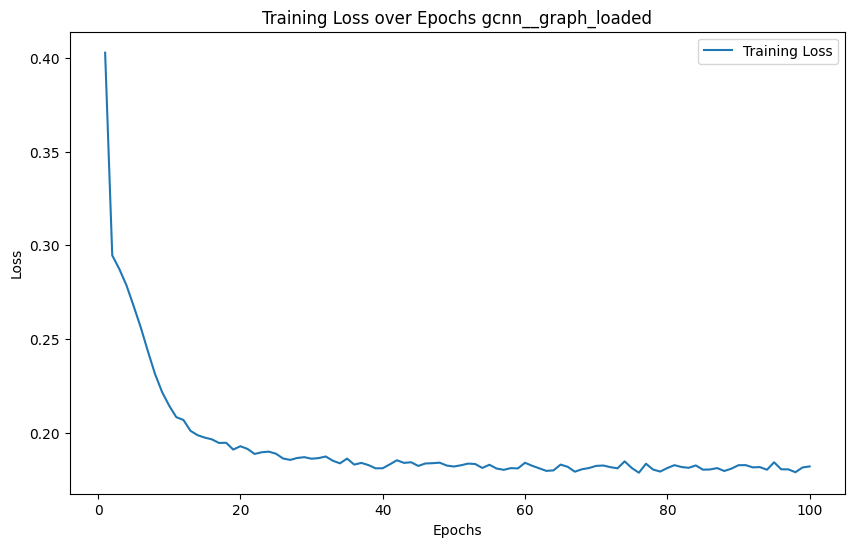

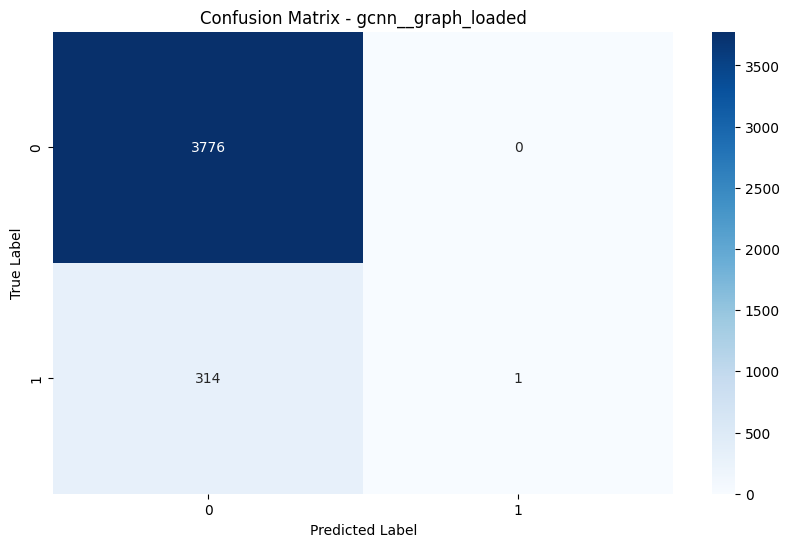

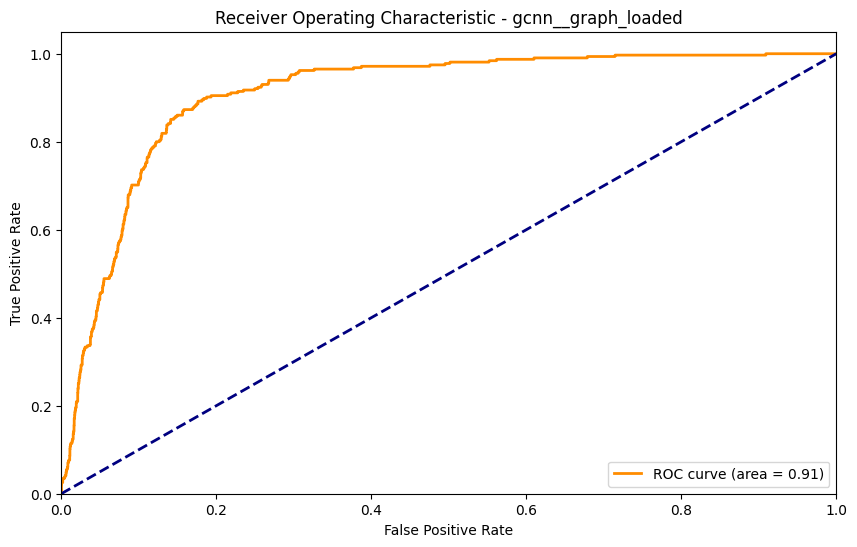

type7_label_
2342


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.5208439723803446
Epoch 2, Loss: 0.4299238229600283
Epoch 3, Loss: 0.36885137841678584
Epoch 4, Loss: 0.3258299626983129
Epoch 5, Loss: 0.32103399903728413
Epoch 6, Loss: 0.31570590889224637
Epoch 7, Loss: 0.31186160087012327
Epoch 8, Loss: 0.3083446111816626
Epoch 9, Loss: 0.30780107771547943
Epoch 10, Loss: 0.30406453947608286
Epoch 11, Loss: 0.3016246067216763
Epoch 12, Loss: 0.29856395377562595
Epoch 13, Loss: 0.29862783949535626
Epoch 14, Loss: 0.3008274905956708
Epoch 15, Loss: 0.2960525812724462
Epoch 16, Loss: 0.2963083071204332
Epoch 17, Loss: 0.2973080998143324
Epoch 18, Loss: 0.2937191891698883
Epoch 19, Loss: 0.29632389022467226
Epoch 20, Loss: 0.29620663506480366
Epoch 21, Loss: 0.294953999396127
Epoch 22, Loss: 0.29223379399627447
Epoch 23, Loss: 0.293872287353644
Epoch 24, Loss: 0.29081654276412267
Epoch 25, Loss: 0.29118019371078563
Epoch 26, Loss: 0.29348940022576314
Epoch 27, Loss: 0.2940393047263989
Epoch 28, Loss: 0.29194542350104224
Epoch 29, Loss: 

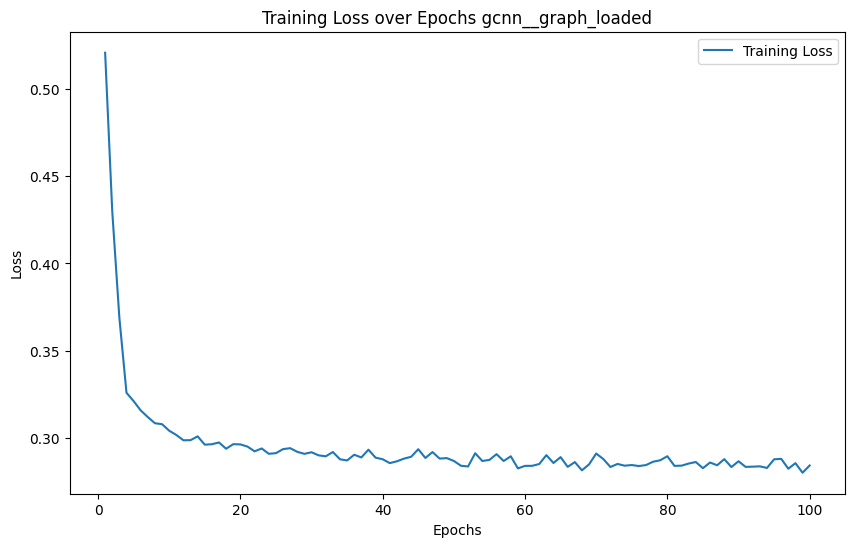

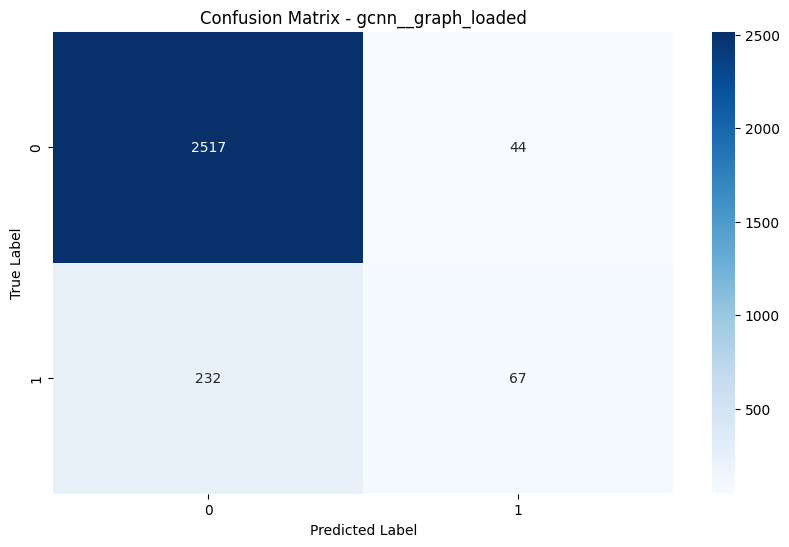

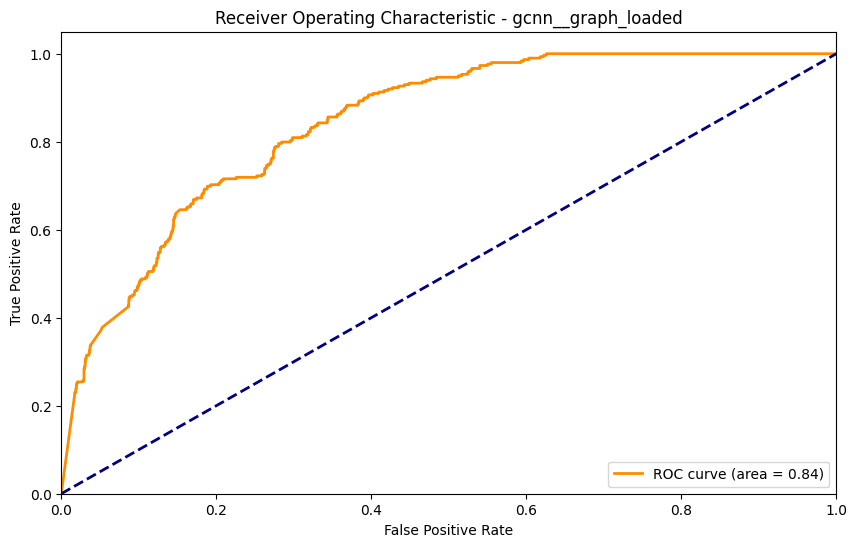

type8_label_
2658


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.49029493584471234
Epoch 2, Loss: 0.4348813408385899
Epoch 3, Loss: 0.38048636799646635
Epoch 4, Loss: 0.32953977483814045
Epoch 5, Loss: 0.30542866639414074
Epoch 6, Loss: 0.2923889120377727
Epoch 7, Loss: 0.2860646216924918
Epoch 8, Loss: 0.2765307357629477
Epoch 9, Loss: 0.2719424966154462
Epoch 10, Loss: 0.26449170222474355
Epoch 11, Loss: 0.25528078399977444
Epoch 12, Loss: 0.24957181639590506
Epoch 13, Loss: 0.24455580475219227
Epoch 14, Loss: 0.23973541990932773
Epoch 15, Loss: 0.23979436726135722
Epoch 16, Loss: 0.2389092899038125
Epoch 17, Loss: 0.2350079992438777
Epoch 18, Loss: 0.23602588070651231
Epoch 19, Loss: 0.2322777459492623
Epoch 20, Loss: 0.23426323617666456
Epoch 21, Loss: 0.233054615588764
Epoch 22, Loss: 0.23131166187004518
Epoch 23, Loss: 0.23422562735060515
Epoch 24, Loss: 0.22338651445836333
Epoch 25, Loss: 0.23101834422450954
Epoch 26, Loss: 0.23091906991045355
Epoch 27, Loss: 0.23101765315158893
Epoch 28, Loss: 0.23121296734375468
Epoch 29, L

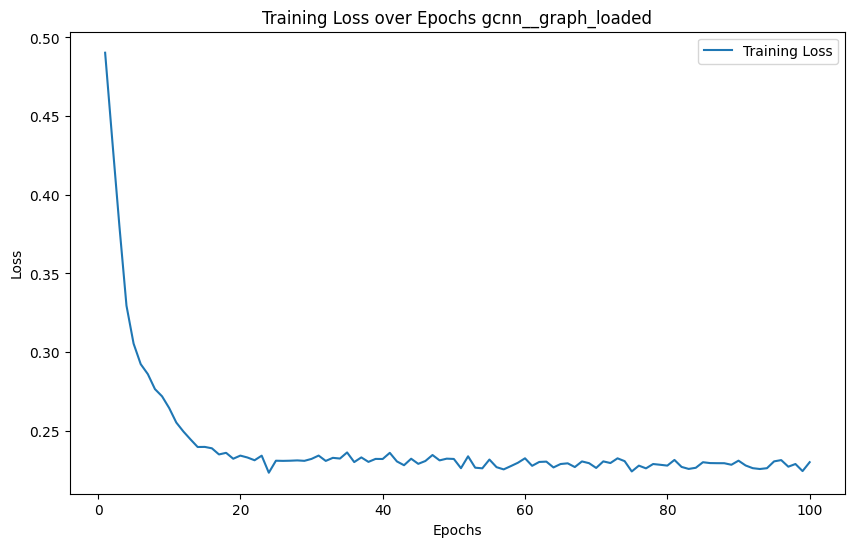

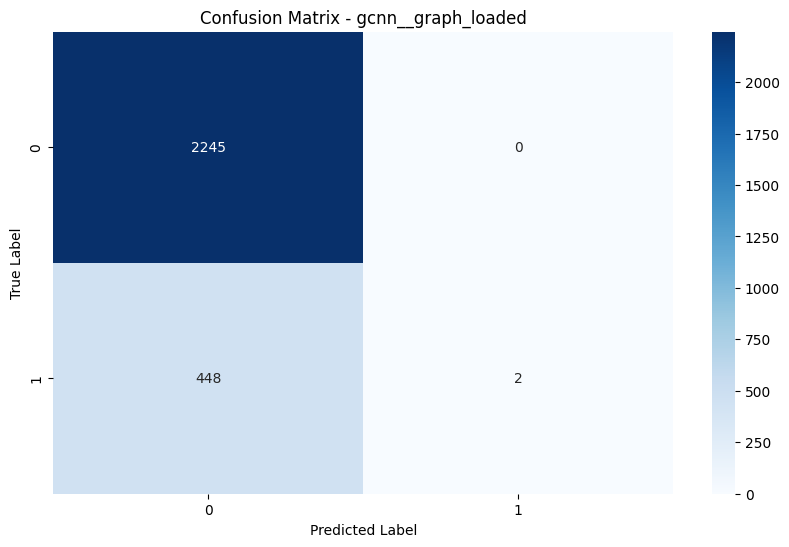

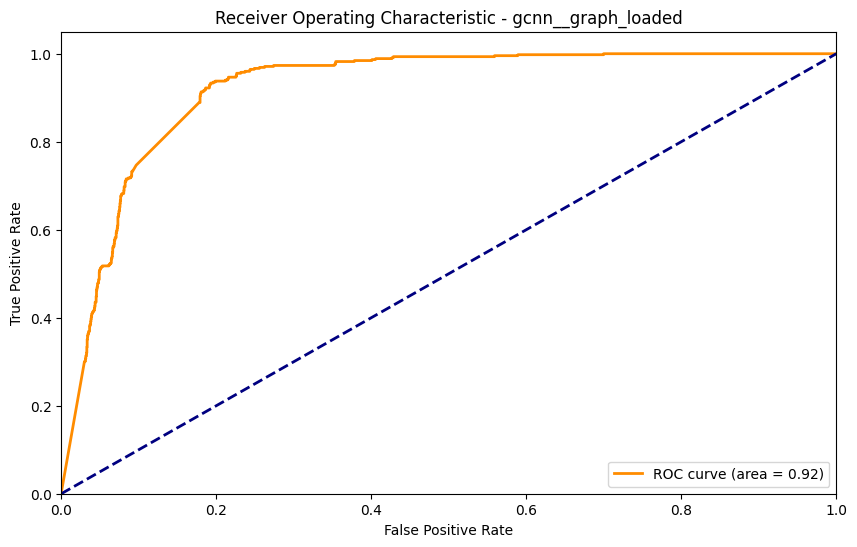

type9_label_
2304


c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.41107312998935286
Epoch 2, Loss: 0.31360310403739705
Epoch 3, Loss: 0.29921697328488034
Epoch 4, Loss: 0.28688925197895837
Epoch 5, Loss: 0.27212318909518857
Epoch 6, Loss: 0.25676732612591163
Epoch 7, Loss: 0.24102289624073925
Epoch 8, Loss: 0.22789311818048066
Epoch 9, Loss: 0.21922476735769533
Epoch 10, Loss: 0.21237743762778302
Epoch 11, Loss: 0.21115598886036405
Epoch 12, Loss: 0.2084944287643713
Epoch 13, Loss: 0.20268752031466541
Epoch 14, Loss: 0.20268956162765914
Epoch 15, Loss: 0.20112042150953235
Epoch 16, Loss: 0.19460277785273158
Epoch 17, Loss: 0.19305463631947836
Epoch 18, Loss: 0.19204055485041702
Epoch 19, Loss: 0.19456622691131106
Epoch 20, Loss: 0.18994327258391708
Epoch 21, Loss: 0.1967640565890892
Epoch 22, Loss: 0.19132081349836846
Epoch 23, Loss: 0.1879763137549162
Epoch 24, Loss: 0.18802186561857953
Epoch 25, Loss: 0.19007628184615397
Epoch 26, Loss: 0.1877375988691461
Epoch 27, Loss: 0.18994283833194012
Epoch 28, Loss: 0.1878547288258286
Epoch 

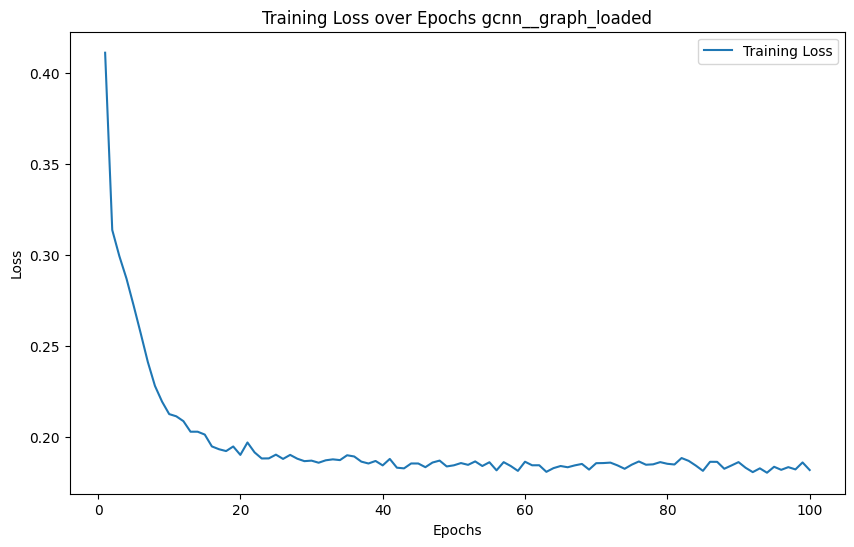

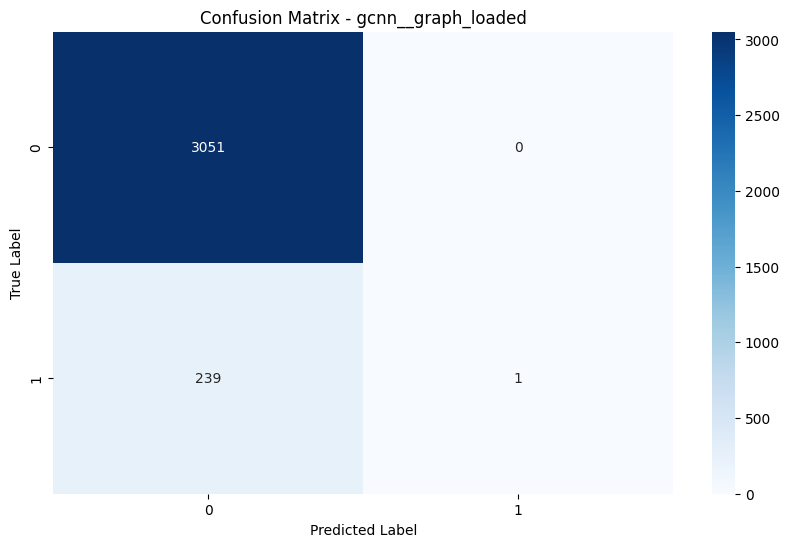

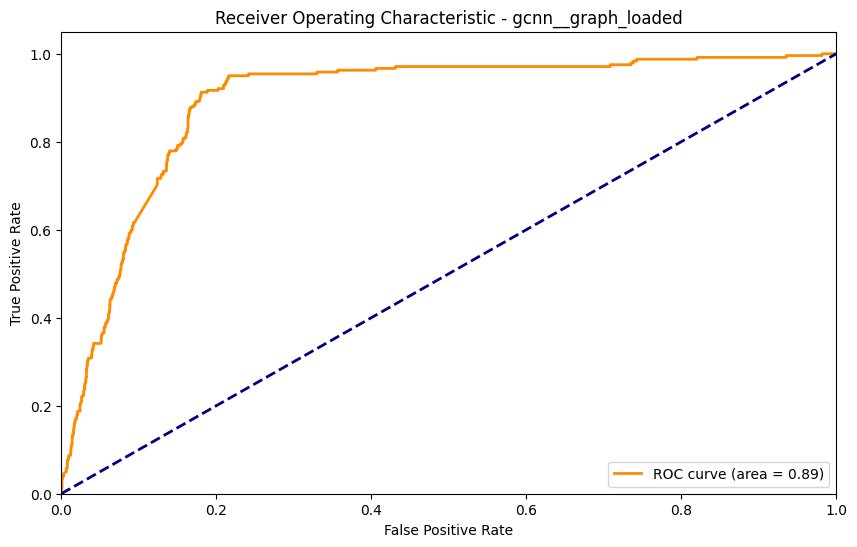

In [12]:
result_dict = {}
for file_path in xlsx_files:
    

    if new_execution_flag == 1:
        data = pd.read_excel(file_path)
        data['can_id'] = data['can_id'].astype(str)
    
    label_key = os.path.basename(file_path).split('.')[0][0:12]
    print(label_key)

    output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
    visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
    result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    if new_execution_flag == 1:
        pyg_data_list = preprocess_data(data,output_dir,visualization_dir)
    else:
        pyg_data_list = load_saved_graphs(output_dir)

    print(len(pyg_data_list))
    # break
    train_size = int(0.7 * len(pyg_data_list))
    train_data = pyg_data_list[:train_size]
    test_data = pyg_data_list[train_size:]

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # _,_,acc = run_SageConv(train_loader,test_loader,'SageConv',result_dir)
    # _,_,gat_acc = run_GAT(train_loader,test_loader,'GAT',result_dir)
    # _,_,transformer_acc = run_GTransformer(train_loader,test_loader,'Transformer',result_dir)
    # # _,_,sageConv_lstm_acc =run_SageConv_lstm(train_loader,test_loader,'sageConv_lstm',result_dir)
    _,_,gcnn_acc =run_GCnn(train_loader,test_loader,'gcnn__graph_loaded',result_dir)

    result_dict[label_key] = {
        # 'GSageConv': acc,
        # 'GAT': gat_acc,
        # 'GTransformer': transformer_acc,
        # 'GSage_conv_lstm': sageConv_lstm_acc,
        'GCNN': gcnn_acc
    }

    # print(result_dict)